## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Get the Data

In [4]:
mnist=pd.read_csv("Mnist_combined.csv",index_col=0)

In [5]:
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist.shape

(70000, 785)

## 3. Convert the Data into Tensor Dataset

In [7]:
mnist = mnist.sample(20000)

In [8]:
mnist.shape

(20000, 785)

In [9]:
X = mnist.drop(labels = "label" ,axis = 1)

# In this , we actually don't need labels
Y = mnist["label"]

In [10]:
Y.head()

1235     9
36058    9
5156     2
13408    0
10204    0
Name: label, dtype: int64

In [11]:
data_np = X.to_numpy()
labels_np = Y.to_numpy()

In [12]:
data_np[0].shape

(784,)

In [13]:
labels_np.shape

(20000,)

In [14]:
labels_np

array([9, 9, 2, ..., 9, 1, 6], dtype=int64)

In [15]:
#labels_np=labels_np[:,None]

In [16]:
# Normalize the data(predictors) to a range of [0 1]
dataNorm = data_np / np.max(data_np)

In [17]:
dataNorm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Converting Numpy array to Pytorch Array

In [18]:
# convert to a pytorch tensor
data = torch.tensor(dataNorm).float()

# Note: "long" format for CCE : Multiclass classification
labels = torch.tensor(labels_np).long() 

In [19]:
labels

tensor([9, 9, 2,  ..., 9, 1, 6])

## 4. Create and validate the model

In [20]:
# create a class for the model
def createTheMNIST_AE_Net(LR):

    class MNIST_AE_Net(nn.Module):
        
        def __init__(self):
            super().__init__()

            ### Input layer
            self.input = nn.Linear(784,250)

            ### Encode Layer
            self.enc = nn.Linear(250,50)
            
            ### Latent layer
            self.lat = nn.Linear(50,250)
            
            ### decoder layer
            self.dec = nn.Linear(250,784)
            

        # forward pass
        def forward(self,x):
            
            # Input  Layer
            x = F.relu( self.input(x) ) 
            # Encode layer
            x = F.relu( self.enc(x) )
            # latent Layer
            x = F.relu(self.lat(x))
            
            # since, Predictors have range between 0 and 1
            # Therefore, using sigmoid as an activation function
            y = torch.sigmoid(self.dec(x))
            return y
        

    # create the model instance
    ANN_AE_model = MNIST_AE_Net()

    # loss function : Negative Log-Likelihood Loss function
    lossfunc = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(ANN_AE_model.parameters(),lr=LR)

    return ANN_AE_model, lossfunc, optimizer

### Testing the model

In [21]:
# Test the model with a bit of data
net,lossfun,optimizer = createTheMNIST_AE_Net(LR=0.001)

X = data[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


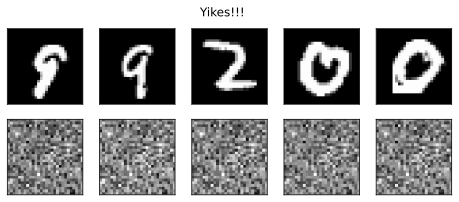

In [22]:
# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(8,3), dpi=145)

for i in range(5):
    
    axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
    axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Yikes!!!')

plt.show()

## 5. Model Training

In [23]:
def function2trainTheModel(Model, lossfunc, optimizer, predictors, epochs):

    # initialize losses
    losses = torch.zeros(epochs)

    # loop over epochs
    for epochi in range(epochs):

        # select a random set of images
        randomidx = np.random.choice(predictors.shape[0],size=32)
        X = predictors[randomidx,:]

        # forward pass and loss
        yHat = Model(X)
        loss = lossfunc(yHat,X)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses in this epoch
        losses[epochi] = loss.item()
        # end epochs

    # function output
    return losses,Model

## 6. Experiment

In [24]:
# Create the network
ANN_AEmodel, Lossfunc, Optimizer = createTheMNIST_AE_Net(LR=0.001)

# Model Training
Losses,trained_model =  function2trainTheModel(Model=ANN_AEmodel, 
                                               lossfunc=Lossfunc, 
                                               optimizer=Optimizer, 
                                               predictors=data,
                                               epochs=1000)


#### (a) Visualization : Losses versus epochs 

Final loss: 0.0181


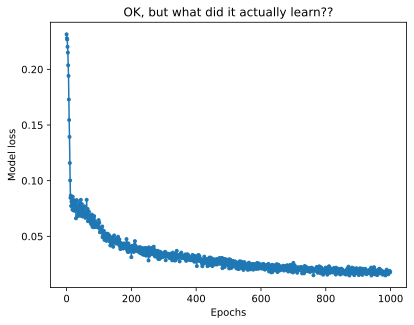

In [25]:
print(f'Final loss: {Losses[-1]:.4f}')

# visualize the losses
plt.plot(Losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('OK, but what did it actually learn??')

plt.show()

#### (b) Visulization : output from the trained model

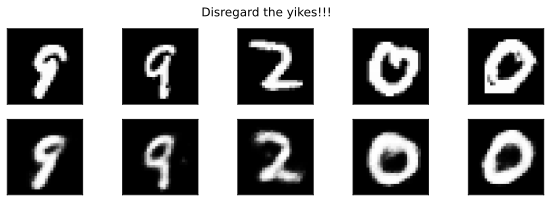

In [26]:
# Repeat the visualization when testing the model
X = data[:5,:]
yHat = trained_model(X)


# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3), dpi=145)

for i in range(5):
    
    axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
    axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
    
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Disregard the yikes!!!')

plt.show()

## 7.Add noise to see a use case of an autoencoder

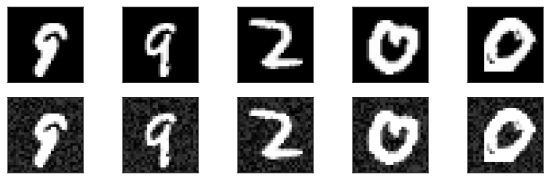

In [27]:
# grab a small set of images
X = data[:10,:]

# add noise : using uniform distribution
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3), dpi=145)

for i in range(5):
    axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
    axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.show()

#### Run through the model

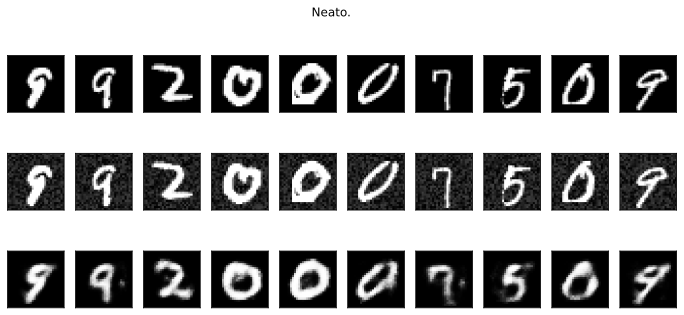

In [28]:
Y = trained_model(Xnoise)

# Show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5) , dpi=145)

for i in range(10):
    axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
    axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
    axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
    axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.suptitle('Neato.')
plt.show()